# Honours Project: Building a Server-Based Evolutionary Algorithm to Schedule Calorie Burnout Plans (Sandbox)

## Imports

In [3]:
import random as rnd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import csv
import os
import time as t

from matplotlib.colors import LinearSegmentedColormap
from typing_extensions import override

## Utilities

In [5]:
class CsvHandler:
    """
    This class handles CSV I/O operations. A single class instance represents a single CSV file, provided its directory,
    name, and column names.
    :var _path: `str` - The path to the directory that should hold the CSV file.
    """

    def __init__(self, dest_dir: str, filename: str, cols: list) -> None:
        """
        This class handles CSV I/O operations. A single class instance represents a single CSV file, provided its directory,
        name, and column names.
        :param dest_dir: `str` - Destination directory where the CSV file should reside. The provided directory will be created if it does not exist.
        :param filename: `str` -  Name of the CSV file, including the `.csv` extension.
        :param cols: `list` - The list of column names for the CSV file.
        """
        self._path = dest_dir
        self._check_directory()
        self._path += filename

        if self._csv_empty():
            with open(self._path, 'w', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(cols)

    def _check_directory(self) -> None:
        """
        Checks if provided directory exists. If not, the directory is created.
        """
        if not os.path.exists(self._path):
            os.makedirs(self._path)

    def _csv_empty(self) -> bool:
        """
        Checks if provided CSV file is empty.

        :return: `True` if CSV file is empty, `False` otherwise.
        :exception FileNotFoundError: If CSV file does not exist.
        """
        try:
            with open(self._path, 'r', newline='') as csvfile:
                reader = csv.reader(csvfile)
                cols = next(reader, None)
                if cols is None:
                    return True
                first_row = next(reader, None)
                return first_row is None

        except FileNotFoundError:
            print("File not found.")
            return True

    def append(self, vals: list) -> None:
        """
        Adds a new row to the CSV file, provided a list of values.
        :param vals: The list of row values to be added to the CSV file.
        :type vals: List of values to fill a row.
        :exception ValueError: When an unexpected value is provided for `vals`.
        """
        if vals is None or not isinstance(vals, list):
            raise ValueError("List of values must be provided in order to write.")
        if not isinstance(vals, list):
            raise ValueError(f"Input parameter must be a list. Got {type(vals)}.")

        with open(self._path, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(vals)

### Timer

In [7]:
class Timer:
    """
    Used to measure execution time using Python's library, `time`.
    :var _start: `float` - Start time.
    :var _end: `float` - End time.
    """
    def __init__(self) -> None:
        self._start: float = 0.0
        self._end: float = 0.0

    def start(self) -> None:
        """
        Starts the timer.
        """
        self._start =  t.time()

    def stop(self) -> None:
        """
        Stops the timer and return the elapsed time.
        """
        self._end = t.time()

    def result(self) -> float:
        """
        :return: elapsed time, rounded float to 2 decimal places.
        """
        return round(self._end - self._start, 2)

In [8]:
target = 10000
c = 0
timer = Timer()
timer.start()
for i in range(target):
    c += 1
    print(f"\r {i+1}/{target}", end='')
timer.stop()

 10000/10000

In [9]:
timer.result()

0.02

### Errors

In [11]:
import datetime as dt


class Base(Exception):
    def __init__(self, msg: str, err_code: int):
        self.dt = self._get_date_time()
        self.msg: str = msg
        self.err_code: int = err_code
        super().__init__(self.msg)

    def __str__(self):
        return f"[{self.dt['date']} {self.dt['time']}] ERR{self.err_code}-{self.msg}"



    @staticmethod
    def _get_date_time() -> dict:
        now = dt.datetime.now()
        date = now.strftime("%Y-%m-%d")
        time = now.strftime("%H:%M:%S")
        return {"date": date, "time": time}



class AlgorithmParamsError(Base):
    def __init__(self, params_obj):
        super().__init__(
            f"The algorithm expects a `Parameters` object. The type of the parameter is {type(params_obj).__name__}.",
            1001
        )


class ParameterRangeError(Base):
    def __init__(self, value, hi, lo):
        super().__init__(
            f"Invalid parameter range. Expected between {lo} and {hi}. Got {value}.",
            1002
        )

    def __str__(self) -> str:
        return super().__str__()


class UnexpectedValueError(Base):
    def __init__(self, value, expected):
        super().__init__(
            f"Unexpected value. Expected {expected}. Got {value}.",
            1003
        )

class UnexpectedTypeError(Base):
    def __init__(self, actual_type, expected_type):
        super().__init__(
            f"Unexpected type. Expected {expected_type.__name__}. Got {actual_type.__name__}.",
            1004
        )

### Validation

In [13]:
class Validation:
    @staticmethod
    def range_validation(x, hi, lo) -> None:
        """
        Tests variable's value against its range.
        :param x: Actual value
        :param hi: Upper bound
        :param lo: Lower bound
        :exception ParameterRangeError: If `x` is found out of bounds
        """
        if not lo <= x <= hi:
            raise ParameterRangeError(x, hi, lo)

    @staticmethod
    def value_validation(x, expected) -> None:
        """
        Tests a variable for a specific value.
        :param x: Actual value
        :param expected: Expected value
        :exception UnexpectedValueError: If `x` is not of the expected value.
        """
        if not x == expected:
            raise UnexpectedValueError(x, expected)

    @staticmethod
    def type_validation(x, expected) -> None:
        """
        Tests a variable's actual type against an expected type.
        :param x: The variable to be tested
        :param expected: Expected type
        :exception UnexpectedTypeError: If `x` is not of the expected type.
        """
        if not isinstance(x, expected):
            raise UnexpectedTypeError(type(x), expected)

    # @staticmethod
    # def

In [14]:
Validation.range_validation(5,10,1)
Validation.value_validation(60,60)
Validation.type_validation(False, bool)

## Defaults

In [16]:
class Defaults:
    MAX_EXERCISES_PER_SCHEDULE = 10
    """Maximum number of exercise types per schedule."""
    MAX_EXERCISE_DURATION = 12 * 60
    """Maximum duration of an exercise in minutes."""
    MAX_DAILY_DURATION = 8 * 60
    """Maximum duration of the daily workout in minutes."""
    MAX_BASE_10_SCHEDULE = 2 ** 7 - 1
    """Maximum base 10 binary representation of a weekly schedule."""
    MAX_DAILY_EXERCISE_COUNT = 10
    """Maximum number of exercises in a day."""

    LARGE_COMPENDIUM_PATH = './../data/compendium_large.csv'
    """Path to the large Compendium of Physical Activities csv file (522 rows)."""
    MEDIUM_COMPENDIUM_PATH = './../data/compendium_medium.csv'
    """Path to the large Compendium of Physical Activities csv file (260 rows)."""
    SMALL_COMPENDIUM_PATH = './../data/compendium_small.csv'
    """Path to the large Compendium of Physical Activities csv file (65 rows)."""


    MAP_BINS = 20
    """Number of bins in a single dimension for the map of elites."""
    WEEK = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    """List of names of days of the week."""


    MIN_DAILY_EXERCISE_COUNT = 0
    """Minimum number of exercises in a day."""
    MIN_EXERCISE_DURATION = 15
    """Minimum duration of an exercise in minutes."""
    MIN_DAILY_DURATION = 0
    """Minimum duration of the daily workout in minutes."""
    MIN_BASE_10_SCHEDULE = 1
    """Minimum base 10 binary representation of a weekly schedule."""

    @staticmethod
    def exercise_duration_range() -> range:
        """
        :return: `range` - The default range of minutes for a single exercise's duration.
        """
        return range(15, Defaults.MAX_EXERCISE_DURATION + 1, 15)

    @staticmethod
    def daily_duration_range() -> range:
        """
        :return: `range` - The default range of minutes for a single day of workout.
        """
        return range(Defaults.MIN_DAILY_DURATION, Defaults.MAX_DAILY_DURATION + 1)

    @staticmethod
    def base10_schedule_range() -> range:
        """
        :return: `range` - The default range of base 10 binary values for determination of a weekly schedule.
        """
        return range(Defaults.MIN_BASE_10_SCHEDULE, Defaults.MAX_BASE_10_SCHEDULE + 1)

    @staticmethod
    def daily_exercise_count_range():
        """
        :return: `range` - The default range of numbers of exercises in a single day.
        """
        return range(Defaults.MAX_DAILY_EXERCISE_COUNT, Defaults.MAX_DAILY_EXERCISE_COUNT + 1)

## Exercise Repository

In [18]:
class ExerciseRepository:
    """
    A local repository of loaded exercises, where information necessary for
    computation are stored, such as activities' MET (Metabolic Equivalent) values.
    :var _data_df: `pandas.DataFrame` - Stores the loaded database of exercises with names, MET Values, categories, and indexes. 
    """
    def __init__(self, path:str) -> None:
        """
        A repository instance is created by loading raw data from a source. Raw data is placed into an accessible
        list, of which size is also monitored.\n
        Raw data is currently loaded from CSV file using a CSV reader, which returns the content as a dictionary for
        each CSV row. Each dictionary is stored in a list.
        """
        self._data_df: pd.DataFrame | None = None        
        self._load(path)

    def __str__(self) -> str:
        met_rng: range = self.met_range()
        
        s = "EXERCISE REPOSITORY:\n"
        s += f"         Size: {self.size()}\n"
        s += f"    MET Range: {met_rng.start} - {met_rng.stop}\n"
        s += f"      Columns: {list(self._data_df.columns)}\n"
        
        return s

    def show(self) -> pd.DataFrame:
        """
        Prints the dictionaries within the list of raw data.
        """
        print(self._data_df)


    def size(self) -> int:
        """
        :return: The size of the Compendium.
        """
        return len(self._data_df)


    def item_at(self, index: int) -> pd.Series:
        """
        :param index: Item index within the repository.
        :return: The item at the specified index.
        """
        return self._data_df.iloc[index]

    def met_range(self) -> range:
        """
        Calculates the highest and lowest values of MET values by placing them in a list and applying `max()` and
        `min()` functions on the list to obtain upper and lower bounds for the range. The upper bound is rounded to
        greatest integer, while the lower bound is rounded to lowest integer.
        :return: A range from the lower bound to the upper bound, minus 1.
        """
        l = [float(self.item_at(i)['met']) for i in range(self.size())]
        return range(math.floor(min(l)), math.ceil(max(l)))

    def _load(self, path:str) -> None:
        """
        Read data from a CSV file and store as a dataframe.
        :param path: `str` - Path to the CSV file.
        """
        self._data_df = pd.read_csv(path)

In [19]:
repo = ExerciseRepository(Defaults.SMALL_COMPENDIUM_PATH)
print(repo)
repo.show()

EXERCISE REPOSITORY:
         Size: 96
    MET Range: 1 - 15
      Columns: ['idx', 'name', 'met', 'tags']

    idx                         name  met                   tags
0     0           Bicycling, general  7.0              Bicycling
1     1             Aerobic, general  7.3  Conditioning Exercise
2     2                 Calisthenics  4.4  Conditioning Exercise
3     3     Cicuit training, general  5.5  Conditioning Exercise
4     4  Elliptical trainer, general  7.0  Conditioning Exercise
..  ...                          ...  ...                    ...
91   91             Tai chi, general  3.6                 Sports
92   92              Tennis, general  6.8                 Sports
93   93     Trampoline, recreational  6.3                 Sports
94   94          Volleyball, general  5.5                 Sports
95   95           Wallyball, general  7.0                 Sports

[96 rows x 4 columns]


In [20]:
print("Repo Exercise:")
index = 94
print(f"        Index:  {index}")
exercise = repo.item_at(index)
print(f"         Name:  {exercise['name']}")
print(f"          Tag:  {exercise['tags']}")
print(f"    MET Value:  {exercise['met']}")
print(f" Data Type: {type(exercise)}")

Repo Exercise:
        Index:  94
         Name:  Volleyball, general
          Tag:  Sports
    MET Value:  5.5
 Data Type: <class 'pandas.core.series.Series'>


## Configurations

In [22]:
class Config:
    """
    Algorithm configurations class, sets dependencies for the algorithm, pre-determined by the user and administrator.
    The functionality of this class consists of getters and setters that alter instance variables that define the
    algorithm's configuration settings.

    :param parameters: A `Parameters` instance obtained from the client class that instantiates this class.
    """
    def __init__(self, init_weight: float, target_weight: float, period: int) -> None:
        # Assign
        self._bins: int = Defaults.MAP_BINS
        self._repo: ExerciseRepository = ExerciseRepository(Defaults.LARGE_COMPENDIUM_PATH)

        # User Parameters
        self._init_weight: float = init_weight
        self._target_weight: float = target_weight
        self._period: int = period

        # Initialise ranges
        self._exercise_index_range: range = range(0, self._repo.size())
        self._exercise_duration_range: range = Defaults.exercise_duration_range()
        self._daily_exercise_count_range: list = Defaults.daily_exercise_count_range()
        self._daily_duration_range: range = Defaults.daily_duration_range()
        self._base10_schedule_range: range = Defaults.base10_schedule_range()

        # Mutation Rates
        self._mutation_rate: float = 0.7
        self._alter_rate: float = 0.6
        self._add_rate: float = 0.2
        self._delete_rate: float = 0.2

    def __str__(self) -> str:
        s = 'CONFIGURATIONS:\n'
        s += f'Number of Map Bins: {self._bins}\n'
        s += f'{self._repo}\n'
        s += f'Initial Weight: {self._init_weight}\n'
        s += f'Target Weight: {self._target_weight}\n'
        s += f'Period: {self._period}\n'
        s += f'Exercise Index Range: {self._exercise_index_range}\n'
        s += f'Exercise Duration Range: {self._exercise_duration_range}\n'
        s += f'Daily Duration Range: {self._daily_duration_range}\n'
        s += f'Daily Duration Count Range: {self._daily_exercise_count_range}\n'
        s += f'Base10 Schedule Range: {self._base10_schedule_range}\n'
        return s

    @staticmethod
    def _range_check(lo: int, hi: int, step: int) -> bool:
        """
        Conducts validation on input ranges.
        :param lo: Lower range bound (inclusive)
        :param hi: Upper range bound (inclusive)
        :param step: Steps between each element in the range.
        :return: `True` if valid range is provided. `False` if no ranges are provided.
        """
        # Input check
        if hi is None and lo is None:
            return True

        if (hi is None) != (lo is None):
            raise ValueError(f'`lo`, `hi`, and `step` must all be provided, or both must be `None` for default.')

        # Type check
        if not (type(hi) is int and type(lo) is int and type(step) is int):
            raise ValueError(f'Upper and lower bounds and steps, `lo`, `hi`, `step`, must be integers. Got {type(lo)}, {type(hi)}, and {type(step)}.')

        # Inequality check
        if hi <= lo:
            raise ValueError(f'Upper bound, `hi`, must be greater than than the lower bound, `lo`. Got {hi} > {lo}.')

        # Step check
        if lo % step != 0 or hi % step != 0:
            raise ValueError(f'Input bounds must be divisible by {step}.')

        return True

    # ==================================================================================================================
    #       SETTERS
    # ==================================================================================================================

    def set_exercise_duration_range(self, lo: None | int = None, hi: None | int = None) -> None:
        """
        Sets the range of exercise durations that will be allowed for the algorithmic process. The result is either a
        range, defined by the user, or a default if the respective parameter is found to be `None`. An exercise has an
        absolute minimum duration of 15 minutes, and any other duration is a multiple of 15.
        """
        parameters_present = self._range_check(lo, hi, 15)
        rng = range(lo, hi + 1, 15) if parameters_present else Defaults.exercise_duration_range()
        self._exercise_duration_range = rng

    def set_base10_schedule_range(self, lo: None | int = None, hi: None | int = None) -> None:
        """
        Sets the range of base10 schedules that will be allowed for the algorithmic process. The result is either a
        base-2 weekly schedule representation, defined by the user, or a default if the respective parameter is found to
        be `None`.
        """
        parameters_present = self._range_check(lo, hi, 1)
        rng = range(lo, hi + 1) if parameters_present else Defaults.base10_schedule_range()
        self._base10_schedule_range = rng

    def set_daily_duration_range(self, lo: None | int = None, hi: None | int = None) -> None:
        """
        Sets the range of daily durations that will be allowed for the algorithmic process. The result is either a
        `range`, or a default if the respective parameter is found to be `None`.
        :param hi: The upper bound for the range, inclusive of `hi`.
        :param lo: The lower bound for the range, inclusive of `lo`.
        :raise ValueError: If only one bound is provided, or when either of the bounds is not an integer.
        """
        parameters_present = self._range_check(lo, hi, 15)
        rng = range(lo, hi + 1, 15) if parameters_present else Defaults.daily_duration_range()
        self._daily_duration_range = rng

    def set_daily_exercise_count_range(self, lo: None | int = None, hi: None | int = None, breaks: bool = True) -> None:
        """
        Sets the range of daily exercise counts that will be allowed for the algorithmic process. The result is either
        a list of possible exercise counts, specified by the user, or a default if the respective parameter is found to
        be `None`.
        :return:
        """
        parameters_present = self._range_check(lo, hi, 1)
        rng = (
                ([0] if breaks else [])
                + list(range(lo, hi + 1) if parameters_present else Defaults.daily_exercise_count_range())
        )
        self._daily_exercise_count_range = rng

    # ==================================================================================================================
    #       GETTERS
    # ==================================================================================================================

    def repository(self) -> ExerciseRepository:
        """
        :return: The stored `ExerciseRepository` object, containing recorded list of available exercises.
        """
        return self._repo

    def initial_weight(self) -> float:
        """
        :return: The initial weight at the time of schedule creation.
        """
        return self._init_weight

    def target_weight(self) -> float:
        """
        :return: The weight to be achieved by the user.
        """
        return self._target_weight

    def period(self) -> int:
        """
        :return: The period by which target weight is to be achieved.
        """
        return self._period

    def exercise_index_range(self) -> range:
        """
        :return: The range of exercise indexes as defined by the data source, where activities are originally stored.
        """
        return self._exercise_index_range

    def exercise_duration_range(self) -> range:
        """
        :return: The range of allowed durations, defined by the user, for a single exercise.
        """
        return self._exercise_duration_range

    def daily_exercise_count_range(self) -> list:
        """
        :return: The range of numbers of activities, defined by the user, that are allowed to take place in a single day.
        """
        return self._daily_exercise_count_range

    def daily_duration_range(self) -> range:
        """
        :return: The range of combined exercise durations, defined by the user, that are allowed to take place in a single day.
        """
        return self._daily_duration_range

    def base10_schedule_range(self) -> range:
        """
        :return: The range of decimal numbers, represented by a 7-bit, binary number (0-127).
        """
        return self._base10_schedule_range

    def bins(self) -> int:
        """
        :return: The number of bins on the Map of Elites in a single dimension.
        """
        return self._bins

    def mutation_rate(self) -> float:
        """
        :return: The rate of the super-mutation.
        """
        return self._mutation_rate

    def alteration_rate(self) -> float:
        """
        :return: The rate of the alteration sub-mutation.
        """
        return self._alter_rate

    def addition_rate(self) -> float:
        """
        :return: The rate of the addition sub-mutation.
        """
        return self._add_rate

    def deletion_rate(self) -> float:
        """
        :return: The rate of the deletion sub-mutation.
        """
        return self._delete_rate

In [23]:
w0, wt, P = 76, 64, 12

config = Config(w0, wt, P)

print(config)

CONFIGURATIONS:
Number of Map Bins: 20
EXERCISE REPOSITORY:
         Size: 515
    MET Range: 1 - 23
      Columns: ['idx', 'name', 'met', 'tags']

Initial Weight: 76
Target Weight: 64
Period: 12
Exercise Index Range: range(0, 515)
Exercise Duration Range: range(15, 721, 15)
Daily Duration Range: range(0, 481)
Daily Duration Count Range: range(10, 11)
Base10 Schedule Range: range(1, 128)



In [24]:
w0, wt, P = 76, 64, 12

config = Config(w0, wt, P)

config.set_daily_exercise_count_range(3,6)
config.set_daily_duration_range(60, 120)
config.set_exercise_duration_range(30, 120)
config.set_base10_schedule_range(30, 110)

print(config)

CONFIGURATIONS:
Number of Map Bins: 20
EXERCISE REPOSITORY:
         Size: 515
    MET Range: 1 - 23
      Columns: ['idx', 'name', 'met', 'tags']

Initial Weight: 76
Target Weight: 64
Period: 12
Exercise Index Range: range(0, 515)
Exercise Duration Range: range(30, 121, 15)
Daily Duration Range: range(60, 121, 15)
Daily Duration Count Range: [0, 3, 4, 5, 6]
Base10 Schedule Range: range(30, 111)



## Representation

### Gene and Exercise

In [27]:
class Gene:
    """
    The `Gene` represents a combination of phenotypic exercise parameters for the genetic algorithm. A new instance invokes a random generation of genes, defined in the configurations object.
    """

    def __init__(self, config:Config, other=None) -> None:
        """
        A new `Gene` instance is created which initialises randomised genotypic traits,that adheres to the settings
        defined in the configurations object. If another gene is passed in the case of creating a new `Exercise`
        object, the other gene's traits are inherited and passed onto the child class object.
        
        :param config: `Config` - The configuration object from which settings are extracted.
        :param other: `Gene` - The gene object from which traits will be inherited.
        """
        if other is not None:
            if not (isinstance(other, Gene)):
                raise TypeError(f"Improper input parameter type for `other`. Should be `Gene`. Got {type(other)}")

            
        self._config = config

        # Generate and store random gene attribute values
        self._exercise_index = self._random_index() if other is None else other.exercise_index()
        self._duration = self._random_duration() if other is None else other.duration()
        self._base10_schedule = self._random_schedule() if other is None else other.schedule_to_base(10)
        
        # Delete the unused instance
        if other is not None:
            del other

    def __str__(self) -> str:
        return str(self.to_list())

    def _random_index(self) -> int:
        """
        :return: A random exercise index within range.
        """
        return rnd.choice(self._config.exercise_index_range())

    def _random_duration(self) -> int:
        """
        :return: A random exercise duration within range.
        """
        return rnd.choice(self._config.exercise_duration_range())

    def _random_schedule(self) -> int:
        """
        :return: A random base-10 schedule within range (1-127).
        """
        return rnd.choice(self._config.base10_schedule_range())

    def exercise_index(self) -> int:
        """
        :return: The index of the exercise with respect to the exercise repository.
        """
        return self._exercise_index

    def duration(self) -> int:
        """
        :return: The duration of the exercise.
        """
        return self._duration

    def schedule_to_base(self, base: int) -> str | int:
        """
        :return: The weekly exercise schedule as either a binary (base-2) number string, or decimal (base-10) number integer.
        """
        if base == 2:
            return format(self._base10_schedule, '0{}b'.format(7))
        elif base == 10:
            return self._base10_schedule
        else:
            raise ValueError(f"Unexpected number base! Expecting 2 for binary or 10 for decimal. Got {base}.")

    def to_list(self) -> list[int]:
        """
        :return: The gene as a list of phenotypic parameters in the form `[exercise_index, exercise_duration, base10_schedule]`.
        """
        return [self._exercise_index, self._duration, self._base10_schedule]

    def alter(self) -> None:
        """
        Performs an alteration mutation to a random attribute of the gene.
        """
        param_index = rnd.choice(list(range(len(self.to_list()))))

        if param_index == 0: # Generate random index
            self._exercise_index = self._random_index()
        elif param_index == 1: # Generate random duration
            self._duration = self._random_duration()
        elif param_index == 2: # Generate random base-10 schedule
            self._base10_schedule = self._random_schedule()
        else:
            raise ValueError(f"Unexpected value of gene index ({param_index})." )

In [28]:
gene = Gene(config=config)
print(f"Gene {gene}:")
print(f"       Exrcise Index:    {gene.exercise_index()}")
print(f"            Duration:    {gene.duration()}")
print(f"    Base-10 Schedule:    {gene.schedule_to_base(10)}")
print(f"     Base-2 Schedule:    {gene.schedule_to_base(2)}")

Gene [78, 90, 47]:
       Exrcise Index:    78
            Duration:    90
    Base-10 Schedule:    47
     Base-2 Schedule:    0101111


In [29]:
gene.alter()
print(f"Gene {gene}:")
print(f"       Exrcise Index:    {gene.exercise_index()}")
print(f"            Duration:    {gene.duration()}")
print(f"    Base-10 Schedule:    {gene.schedule_to_base(10)}")
print(f"     Base-2 Schedule:    {gene.schedule_to_base(2)}")

Gene [450, 90, 47]:
       Exrcise Index:    450
            Duration:    90
    Base-10 Schedule:    47
     Base-2 Schedule:    0101111


In [30]:
class Exercise(Gene):
    """
    The phenotypic representation of a single gene. Contains concrete information regarding a single exercises.
    :var _name: The exercise name.
    :var _tag: The category of the exercise.
    :var _met: The exercise's MET Value.
    """
    def __init__(self, gene: Gene, config) -> None:
        """
        The phenotypic representation of a single gene. Contains concrete information regarding a single exercises.
        :param gene: `Gene` - The gene instance from which to inherit and translate from.
        :param config: `Config` - The configurations object that stores all necessary settings.
        """
        super().__init__(config, other=gene)
        exercise_series = config.repository().item_at(super().exercise_index())
        self._name: str = exercise_series['name']
        self._tag: str = exercise_series['tags']
        self._met: float = exercise_series['met']

    def name(self) -> str:
        """
        :return: The name of the exercise.
        """
        return self._name

    def tag(self) -> str:
        """
        :return: The category of the exercise.
        """
        return self._tag

    def met(self) -> float:
        """
        :return: The MET Value of the exercise.
        """
        return self._met

    def frequency(self) -> int:
        """
        :return: The weekly frequency of an exercise, calculated by summing bits of its base-2 schedule representation.
        """
        base2_schedule = self.schedule_to_base(2)
        return sum([int(bit) for bit in base2_schedule])

In [31]:
gene = Gene(config=config)
print(f"Gene {gene}:")
print(f"       Exrcise Index:    {gene.exercise_index()}")
print(f"            Duration:    {gene.duration()}")
print(f"    Base-10 Schedule:    {gene.schedule_to_base(10)}")
print(f"     Base-2 Schedule:    {gene.schedule_to_base(2)}")

Gene [504, 30, 46]:
       Exrcise Index:    504
            Duration:    30
    Base-10 Schedule:    46
     Base-2 Schedule:    0101110


In [32]:
gene.alter()
print(f"Gene {gene}:")
print(f"       Exrcise Index:    {gene.exercise_index()}")
print(f"            Duration:    {gene.duration()}")
print(f"    Base-10 Schedule:    {gene.schedule_to_base(10)}")
print(f"     Base-2 Schedule:    {gene.schedule_to_base(2)}")

Gene [504, 30, 31]:
       Exrcise Index:    504
            Duration:    30
    Base-10 Schedule:    31
     Base-2 Schedule:    0011111


### Chromosome and Schedule

In [34]:
class Chromosome:
    """
    A class to represent a single chromosome, which represents a list of exercises
    configured by parameters from Gene super-class. The chromosome also possesses the ability to mutate upon
    invoking the `mutate()` function.
    :var _config: `Config` - The configurations object that holds the necessary settings.
    :var _mutation_rate: `float` - The mutation rate of the chromosome.
    :var _alter_rate: `float` - The alteration sub-mutation rate of the chromosome.
    :var _add_rate: `float` - The addition sub-mutation rate of the chromosome.
    :var _delete_rate: `float` - The deletion sub-mutation rate of the chromosome.
    :var _chromosome: `list[Gene]` - The chromosome as a list of gene objects.
    :var _probability_pool: `list[int]` - A pool of 100 integers of 3 different possibilities, derived by each of the sub-mutation rates.
    """
    def __init__(self, config: Config, other=None) -> None:
        """
        A class to represent a single chromosome, which represents a list of exercises
        configured by parameters from Gene super-class. The chromosome also possesses the ability to mutate upon invoking the `mutate()` function.
        :param config: `Config` - The configurations object that holds the necessary settings.
        :param other: `Chromosome | None` - If provided, this instance will inherit properties of the `other` chromosome instance. Otherwise, new properties are generated.
        """
        if other is not None:
            if not isinstance(other, Chromosome):
                raise TypeError("Improper input parameter type for `other`. Should be `Chromosome`")
        
        self._config: Config = config
        
        self._mutation_rate: float = config.mutation_rate()
        self._alter_rate: float = config.alteration_rate()
        self._add_rate: float = config.addition_rate()
        self._delete_rate: float = config.deletion_rate()

        self._chromosome: list[Gene] = self._generate(5) if other is None else other.genotype_to_list('shallow')

        self._probability_pool: list[int] = (
                [0] * int(self._alter_rate * 100) 
                + [1] * int(self._add_rate * 100) 
                + [2] * int(self._delete_rate * 100)
        )
        self._shuffle_probability_pool(5)

    def __str__(self) -> str:
        """
        :return: The deep representation of the genotype as a string.
        """
        return str(self.genotype_to_list('deep'))

    def _shuffle_probability_pool(self, times: int) -> None:
        """
        Shuffle the probability pool to obtain more randomness. 
        :param times: `int` - The amount of times the pool is to be shuffled.
        """
        for i in range(times):
            rnd.shuffle(self._probability_pool)

    def _generate(self, size: int) -> list[Gene]:
        """
        Generate a random list of genes that will be denoted by the chromosome.
        :param size: `int` - The initial chromosome size.
        :return: 
        """
        l = []
        for _ in range(size):
            l.append(Gene(self._config))
        return l

    def _alter(self) -> None:
        """
        Perform an alteration mutation that randomly alters a random gene's trait.
        """
        chromosome: list[list[int]] = self.genotype_to_list('shallow')
        index = rnd.randrange(0, len(chromosome))
        gene = chromosome[index]
        assert isinstance(gene, Gene), f"Improper type for gene. Got {type(gene)}."
        gene.alter()

    def _add(self) -> None:
        """
        Perform an addition mutation that adds a random new gene to the chromosome.
        """
        if self.size() < Defaults.MAX_EXERCISES_PER_SCHEDULE:
            self._chromosome.append(Gene(self._config))

    def _delete(self) -> None:
        """
        Perform a deletion mutation that removes a random gene from the chromosome.
        :return: 
        """
        size = self.size()
        gene_index = rnd.choice(range(size))
        gene = self._chromosome[gene_index]
        if size > 1:
            self._chromosome.remove(gene)        

    def size(self) -> int:
        """
        :return: The size of the individual in terms of number of genes/exercises.
        """
        return len(self._chromosome)

    def mutate(self) -> None:
        """
        Conducts genetic mutation over the individual based on muation rates specified
        in the configurations.
        """
        chance = rnd.randrange(0,100) / 100
        if chance <= self._mutation_rate:
            sub_mutation_index = rnd.choice(self._probability_pool)
            if sub_mutation_index == 0:
                self._alter()
            elif sub_mutation_index == 1:
                self._add()
            elif sub_mutation_index == 2:
                self._delete()
            else:
                raise ValueError(f"Invalid mutation choice. Got {sub_mutation_index} where element of {set(self._probability_pool)} was expected")
                
    def genotype_to_list(self, depth: str = 'shallow') -> list[Gene] | list[list[int]]:
        """
        Creates and returns the individuals as a list of genotypic exercises.
        :param: `depth` - specifies the depth for the list. If `"deep"`, the output list
        will contain sublists representing genes. `"shallow"` returns a list of respective
        `Gene` objects.
        :return: 1-dimensional list of `Gene` objects, or 2-dimensional list of integers.
        """
        if depth == 'shallow':
            return [gene for gene in self._chromosome]
        elif depth == 'deep':
            return [gene.to_list() for gene in self._chromosome]
        else:
            raise ValueError(f"Unexpected depth parameter, '{depth}'. Expecting 'deep or 'shallow'.")

In [35]:
ind = Chromosome(config)
print(ind)

[[431, 60, 67], [302, 30, 78], [212, 90, 47], [322, 90, 44], [43, 90, 78]]


In [36]:
ind.mutate()
print(ind)

[[431, 60, 67], [302, 30, 48], [212, 90, 47], [322, 90, 44], [43, 90, 78]]


In [37]:
ind = Chromosome(config)
i=0
most = 0
while i < 100:
    ind.mutate()
    size = ind.size()
    if size > most:
        most = size
    i+=1

print(f"Most Exercises: {most}")

Most Exercises: 6


#### Objective Function: Weight Loss Difference

In [39]:
class WeightLossDifference:
    """
    This objective function calculates the difference between target weight, provided by the user, and actual weight
    after completing the generated schedule. This is done by accepting three parameters - initial weight, target
    weight, and time frame in weeks - and performing a simulation run of the schedule, assuming workout consistency
    and no weight gain in parallel, and continuously updating user's weight after each exercise is completed.
    :var _w0: `float` - User's initial weight.
    :var _wt: `float` - User;s target weight.
    :var _P: `float` - Period by which target weight should be achieved.
    :var _schedule: `list` - The ordered schedule as a list.
    """

    def __init__(self, config: Config, schedule: list) -> None:
        """
        This objective function calculates the difference between target weight, provided by the user, and actual weight
        after completing the generated schedule. This is done by accepting three parameters - initial weight, target
        weight, and time frame in weeks - and performing a simulation run of the schedule, assuming workout consistency
        and no weight gain in parallel, and continuously updating user's weight after each exercise is completed.
        :param config: `Config` - The configuration object wit necessary settings.
        :param schedule: `list` - The ordered schedule as a list.
        """
        self._w0: float = config.initial_weight()
        self._wt: float = config.target_weight()
        self._P: int = config.period()
        self._schedule: list = schedule

    def run(self) -> float:
        """
        Run the objective function.
        :return: `float` - The difference between aspired weight and estimated final weight.
        """
        return self._delta()

    def _delta(self) -> float:
        """
        :return: `float` - Absolute value of the difference between aspired weight and final weight.
        """
        final_w = self._final_weight()
        # print("delta", self._ws, final_w)
        return round(abs(self._wt - final_w), 2)

    def _final_weight(self) -> float:
        """
        Compute final weight by conducting a simulation of the schedule over given number of weeks, `self._P`. The
        user's weight is continuously updated, starting from the provided initial weight, `self._w0`.
        :return: `float` - The final estimated weight.
        """
        current_weight = self._w0
        for i in range(self._P):
            # print(f"Week {i + 1}")
            for day in self._schedule:
                for exercise in day:
                    # print("exercise", exercise.features())
                    # print("curr_w", curr_w)
                    current_weight -= self._weight_loss(exercise, current_weight)
        return current_weight

    @staticmethod
    def _weight_loss(exercise, w: float) -> float:
        """
        Calculates estimated weight loss after completing an exercise with current weight, utilising the MET value of
        the exercise.
        :param exercise: `Exercise` - The exercise that is to be completed.
        :param w: `float` - Weigh at the time of the exercise.
        :return: The estimated weight after exercise completion.
        """
        return (0.00013 * exercise.met() * w * exercise.duration()) / 60

#### Schedule

In [41]:
class Schedule(Chromosome):
    """
    The phenotypic representation of a chromosome. An object of this class will hold information regarding all the exercises contained within the schedule.
    :var: _config: `Config` - The configurations object that holds necessary settings.
    :var _exercises: `list[Exercise]` - The unordered list of exercises with no multiplicity.
    :var _schedule_as_list: `list` - The list of exercise occurrences in chronological order.
    :var _base2_schedule: `str` - The binary representation of a weekly schedule.
    :var _fitness: `float` - The fitness value of the schedule.
    """
    def __init__(self, chromosome: Chromosome, config: Config) -> None:
        """
        he phenotypic representation of a chromosome. An object of this class will hold information regarding all the exercises contained within the schedule.
        :param chromosome: `Chromosome` - The chromosome object to be inherited from.
        :param config: `Config` - The configuration object that holds necessary settings.
        """
        super().__init__(config, other=chromosome)        
        self._schedule_as_list: list = []
        self._base2_schedule: str = '0000000'
        self._exercises: list = []
        self._fitness = float('INF')
        self._valid = False

        self._update()

    # String overload
    def __str__(self) -> str:
        week = Defaults.WEEK
        s = ""
        for i in range(len(self._schedule_as_list)):
            day = self._schedule_as_list[i]
            s += f"{(week[i][:3]).upper()}: ["
            for j in range(len(day)):
                e: Exercise = day[j]
                s += f'({e.exercise_index()},{e.duration()}),'
            s += f"{']' if s[-1] == '[' else '\b]'}\n"
        return s

    # ==================================================================================================================
    #       PRIVATE METHODS
    # ==================================================================================================================
    def _update(self) -> None:
        """
        Update the schedule based on the chromosome provided.
        """
        self._decode()
        self._make_schedule()
        self._merge_binary_schedules()
        self._evaluate()

    def _decode(self) -> None:
        """
        Decode the schedule to produce a list of phenotypic exercises.
        :return: 
        """
        exercises = []
        for gene in self.genotype_to_list('shallow'):
            # print(gene)
            e = Exercise(gene, self._config)
            # print(e)
            # if e.is_valid():
            exercises.append(e)
        self._exercises = exercises

    def _make_schedule(self) -> None:
        """
        Reads exercise data to form the ordered schedule as a list of days with exercises.
        """
        week = [[], [], [], [], [], [], []]
        for exercise in self._exercises:
            schedule = exercise.schedule_to_base(2)
            for i in range(7):
                day = int(schedule[i])
                if day == 1:
                    week[i].append(exercise)
                elif day != 0:
                    raise ValueError(f"Unexpected value for weekly binary exercise schedule. Got {schedule[i]}.")
        self._schedule_as_list = week
        
    def _evaluate(self) -> None:
        """
        Calculates the schedule's fitness value.
        """
        wld: float = WeightLossDifference(self._config, self._schedule_as_list).run()
        self._fitness = wld

    def _merge_binary_schedules(self) -> None:
        """
        Merge exercise binary schedules into one.
        """
        b2_total: list[str] = ['0'] * 7
        b10_exercise_schedules: list[int] = [E.schedule_to_base(10) for E in self._exercises]
        for b10 in b10_exercise_schedules:
            b2: str = format(b10, '0{}b'.format(7))
            for i in range(7):
                if b2[i] == '1':
                    b2_total[i] = '1'
        self._base2_schedule = ''.join(b2_total)

    @staticmethod
    def _fill_and_return_matrix(lst: list[list], filler=0) -> np.ndarray:
        """
        Generate an uneven 2D list to a complete Numpy 2D matrix by filling in blanks with a filler value.
        :param lst: `list[list` - The list to be filled.
        :param filler: `int` - The filler value to fill the blanks with.
        :return: `np.ndarray` - A Numpy 2D matrix.
        """
        max_row_length = max(len(l) for l in lst)
        for i in range(len(lst)):
            row_length = len(lst[i])
            if row_length < max_row_length:
                for _ in range(max_row_length - row_length):
                    lst[i].append(filler)
        return np.array(lst)

    # ==================================================================================================================
    #       PUBLIC METHODS
    # ==================================================================================================================    
    def prettify(self) -> None:
        """
        Pretty-print the schedule, illustrating exercises for each day of the week.
        """
        ds = Defaults.WEEK
        s = "=================================================\n"
        s += "   PRETTY SCHEDULE\n"
        s += "=================================================\n\n"

        for i in range(7):
            sch = self._schedule_as_list[i]
            s += f" {ds[i]} ({f"{len(sch)} exercises" if len(sch) > 0 else "REST"}):\n"
            for e in sch:
                s += f"    Activity:  {e.name()}\n"
                s += f"    Duration:  {e.duration()} minutes\n\n"

            s += "-------------------------------------------------\n"
        print(s)

    def is_valid(self) -> bool:
        return self._valid

    def schedule_to_base(self, base: int) -> str | int:
        """
        :param base: `int` - The base to which return the schedule: 2 - binary; 10 - decimal.
        :return: The weekly exercise schedule as either a binary (base-2) number string, or decimal (base-10) number integer.
        """
        if base == 10:
            return format(self._base2_schedule, '0{}b'.format(7))
        elif base == 2:
            return self._base2_schedule
        else:
            raise ValueError(f"Unexpected number base! Expecting 2 for binary or 10 for decimal. Got {base}.")
        
    def phenotype_to_list(self, depth: str = 'shallow') -> list[list[Exercise]] | list[list[list[int]]]:
        """
        Convert the schedule to a 2D list of exercise objects, or a 3D list where the third dimension is the list of exercise details: index, duration, MET Value.
        :param depth: `string` - Specifies the depth of the output list. Can be 'shallow' or 'deep'.
        :return: The 2D or 3D list of exercises.
        """
        if depth == 'shallow':
            return self._schedule_as_list
        elif depth == 'deep':
            l = [[],[],[],[],[],[],[]]
            for i in range(len(self._schedule_as_list)):
                day = self._schedule_as_list[i]
                for j in range(len(day)):
                    e: Exercise = day[j]
                    l[i].append([e.exercise_index(), e.duration(), e.met()])
            return l
        else:
            raise ValueError(f"Unexpected depth! Expecting 'shallow' or 'deep'. Got {depth}.")
        

    # ===== MEASURABLES ================================================================================================
    def mets(self) -> np.ndarray:
        """
        Gets MET values of all exercises within the schedule, organised into their respective days of the week.
        :return: `2darray` - All MET value occurrences.
        """
        arr = []
        schedule = self._schedule_as_list
        for i in range(7):
            day = schedule[i]
            arr.append([])
            for exercise in day:
                arr[i].append(exercise.met())
        return self._fill_and_return_matrix(arr)

    def durations(self) -> np.ndarray:
        """
        Get durations of all exercises within the schedule and organise them into a computable `numpy` matrix.
        :return: `ndarray` - All exercise durations.
        """
        arr = []
        schedule = self._schedule_as_list
        for i in range(7):
            day = schedule[i]
            arr.append([])
            for exercise in day:
                arr[i].append(exercise.duration())
        return self._fill_and_return_matrix(arr)

    def frequencies(self) -> np.ndarray:
        # pass
        """
        Get frequencies of all exercises within the schedule and organise them into a computable `numpy` matrix.
        :return: `ndarray` - All exercise frequencies.
        """
        arr = []
        exercises = self._exercises
        for E in exercises:
            arr.append(E.frequency())
        return np.array(arr)

    def exercise_counts(self) -> np.ndarray:
        """
        Counts the number of exercises for each day of the week.
        :return: `ndarray` - Exercise counts.
        """
        arr = np.array([0] * 7)
        schedule = self._schedule_as_list
        for i in range(7):
            day = schedule[i]
            arr[i] = len(day)
        return arr
    # ===== MEASURABLES ================================================================================================

    def features(self) -> tuple:
        """
        Describe the schedule's features by calculating the mean MET value, mean exercise durations, and mean frequencies to a tuple.
        :return: The tuple of respective descriptor values.
        """
        mean_mets: float = np.mean(self.mets())
        mean_durations: float = np.mean(self.durations())
        mean_frequencies: int = np.mean(self.frequencies())
        return mean_mets, mean_durations, mean_frequencies        

    def fitness(self) -> float:
        """
        :return: The schedule's fitness score.
        """
        return self._fitness

    def exercises(self) -> list[Exercise]:
        """
        :return: The list of exercise phenotypes.
        """
        return self._exercises

In [42]:
ind = Chromosome(config)
print(ind)

s = Schedule(ind, config)
print("=========================================")
print(s)
print(s.phenotype_to_list('deep'))
s.prettify()
print("=========================================")
print(f"\nFITNESS: {s.fitness()}\n")

[[182, 45, 35], [0, 90, 76], [18, 45, 82], [28, 60, 40], [474, 60, 110]]
MON: [(0,90),(18,45),(474,60)]
TUE: [(182,45),(28,60),(474,60)]
WED: [(18,45)]
THU: [(0,90),(28,60),(474,60)]
FRI: [(0,90),(474,60)]
SAT: [(182,45),(18,45),(474,60)]
SUN: [(182,45)]

[[[0, 90, 14.0], [18, 45, 10.3], [474, 60, 11.0]], [[182, 45, 8.0], [28, 60, 8.8], [474, 60, 11.0]], [[18, 45, 10.3]], [[0, 90, 14.0], [28, 60, 8.8], [474, 60, 11.0]], [[0, 90, 14.0], [474, 60, 11.0]], [[182, 45, 8.0], [18, 45, 10.3], [474, 60, 11.0]], [[182, 45, 8.0]]]
   PRETTY SCHEDULE

 Monday (3 exercises):
    Activity:  Bicycling, mountain, uphill, vigorous
    Duration:  90 minutes

    Activity:  Bicycling, stationary, 151-199 watts
    Duration:  45 minutes

    Activity:  Skating Treadmill, 9 - 9.9 mph, 2% grade
    Duration:  60 minutes

-------------------------------------------------
 Tuesday (3 exercises):
    Activity:  Running, jogging stroller, indoors, 5 mph
    Duration:  45 minutes

    Activity:  Bicycling, inte

#### Exercise Counts

In [44]:
pd.DataFrame(s.exercise_counts().T, index=Defaults.WEEK, columns=['Number of Exercises'])

,Number of Exercises
Monday,3
Tuesday,3
Wednesday,1
Thursday,3
Friday,2
Saturday,3
Sunday,1


#### MET Values

In [46]:
pd.DataFrame(s.mets().T, columns=Defaults.WEEK)

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,14.0,8.0,10.3,14.0,14.0,8.0,8.0
1,10.3,8.8,0.0,8.8,11.0,10.3,0.0
2,11.0,11.0,0.0,11.0,0.0,11.0,0.0


In [47]:
print(f"Mean: {s.mets().mean()}")

Mean: 8.071428571428571


#### Durations

In [49]:
pd.DataFrame(s.durations().T, columns=Defaults.WEEK)

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,90,45,45,90,90,45,45
1,45,60,0,60,60,45,0
2,60,60,0,60,0,60,0


In [50]:
print(f"Mean: {s.durations().mean()}")

Mean: 45.714285714285715


In [51]:
pd.DataFrame(s.frequencies(), columns=['Frequency'], index=[E.name() for E in s.exercises()])

,Frequency
"Running, jogging stroller, indoors, 5 mph",3
"Bicycling, mountain, uphill, vigorous",3
"Bicycling, stationary, 151-199 watts",3
"Bicycling, interactive virtual cycling, indoor cycle ergometer",2
"Skating Treadmill, 9 - 9.9 mph, 2% grade",5


In [52]:
print(f"Mean: {s.frequencies().mean()}")

Mean: 3.2


## MAP-Elites

### Algorithm

$$
\begin{align}
&\mathbf{procedure}\space\text{MAP-Elites}: \\
&|\qquad\mathcal{P}\leftarrow\emptyset \\
&|\qquad\mathcal{X}\leftarrow\emptyset \\
&|\qquad\mathbf{for}\space i \to \text{iterations}: \\
&|\qquad|\qquad\mathbf{if}\space i < G: \\
&|\qquad|\qquad|\qquad x\leftarrow\text{new\_solution}() \\
&|\qquad|\qquad\mathbf{else}: \\
&|\qquad|\qquad|\qquad\text{parent}\leftarrow\text{random\_select}(\mathcal{X}) \\
&|\qquad|\qquad|\qquad\text{x}\leftarrow\text{variation}(\text{parent}) \\
&|\qquad|\qquad d \leftarrow\text{descriptor}(x) \\
&|\qquad|\qquad p \leftarrow\text{performance}(x) \\
&|\qquad|\qquad\mathbf{if}\space\mathcal{P}(d) = \emptyset\space\mathbf{or}\space\mathcal{P}(d) < p: \\
&|\qquad|\qquad|\qquad\mathcal{P}(d)\leftarrow p \\
&|\qquad|\qquad|\qquad\mathcal{X}(d)\leftarrow x \\
\end{align}
$$

### Value Scaling

#### Scaled Value

$$
s = \text{int}\left(\frac{r-\min(r)}{c}+1\right)
$$

#### Bin Capacity

$$
c = \frac{\delta}{b}
$$

#### Raw Value Range

$$
\delta = (\max(r)+1)-\min(r)
$$

### Results

In [58]:
class Results:
    """
    This class brings together the necessary results from the algorithm to either return to the user, or for statistical analysis.
    :var _schedules: `list[Schedule]` - List of schedule objects. 
    :var _performances: `numpy.ndarray` - N-dimensional performance matrix with respect to schedule's position on the map of elites.
    :var _data_points: `list[tuple[int]]` - Data points of schedules with respect to their position on the map of elites.
    """
    def __init__(self, map_of_elites) -> None:
        self._schedules: list[Schedule] = map_of_elites.solutions()
        self._performances: np.ndarray = map_of_elites.performances()
        self._data_points: list[tuple[int]] = map_of_elites.data_points()

    def statistics(self, detailed: bool = False) -> pd.DataFrame:
        """
        Gets all statistics from the algorithm's results as a `pandas` dataframe. 
        :param detailed: `bool` - If `True`, statistics for all solutions will be returned. Otherwise, a summary of those statistics will be returned.
        :return: The dataframe of statistics, reflecting the results.
        """
        
        df = None
        if detailed:
            data_dict: dict = {
                'mean_met': [],
                'std_met': [],
                'mean_duration': [],
                'std_duration': [],
                'week_schedule': [],
                'total_exercises': [],
                'mean_frequency': [],
                'performance': []
            }
            for schedule in self._schedules:
                data_dict['mean_met'].append(np.mean(schedule.mets()))
                data_dict['std_met'].append(np.std(schedule.mets()))
                data_dict['mean_duration'].append(np.mean(schedule.durations()))
                data_dict['std_duration'].append(np.std(schedule.durations()))
                week_schedule = schedule.schedule_to_base(2)
                data_dict['week_schedule'].append(week_schedule)
                data_dict['total_exercises'].append(sum(len(day) for day in schedule.phenotype_to_list()))
                data_dict['mean_frequency'].append(np.mean(schedule.frequencies()))
                data_dict['performance'].append(schedule.fitness())
                
                df = pd.DataFrame(data_dict)
        else:
            stats_performance = [
                [self.mean_quality(), self.std_quality(), self.worst_quality(), self.best_quality()],
                [self.mean_duration(), self.std_duration(), self.max_duration(), self.min_duration()],
                [self.mean_met(), self.std_met(), self.max_met(), self.min_met()],
                [self.mean_counts(), self.std_counts(), self.max_count(), self.min_count()]
            ]            
            df = pd.DataFrame(
                stats_performance,
                columns=["Mean","Standard Deviation","Maximum","Minimum"],
                index=["Performance","Exercise Duration","MET Value","Exercises/Day"])
            
        return df

    def schedules(self) -> list[Schedule]:
        """
        :return: The list of schedule objects. 
        """
        return self._schedules

    # ===== MEAN =======================================================================================================
    def mean_quality(self) -> float:
        """
        :return: The mean quality of all best-performing schedules. 
        """
        mean = np.mean(np.array([schedule.fitness() for schedule in self._schedules]))
        return round(mean, 2)

    def mean_duration(self) -> float:
        """
        :return: The mean duration of all best-performing schedules. 
        """
        mean = np.mean(np.concatenate([schedule.durations().flatten() for schedule in self._schedules]))
        return round(mean, 2)

    def mean_met(self) -> float:
        """
        :return: The mean MET Value of all best-performing schedules. 
        """
        mean = np.mean(np.concatenate([schedule.mets().flatten() for schedule in self._schedules]))
        return round(mean, 2)

    def mean_counts(self) -> float:
        """
        :return: The mean exercise count per day for all best-performing schedules. 
        """
        mean = np.mean(np.array([schedule.exercise_counts() for schedule in self._schedules]))
        return round(mean, 2)
    # ===== MEAN =======================================================================================================

    # ===== STANDARD DEVIATION =========================================================================================
    def std_quality(self) -> float:
        """
        :return: The standard deviation of qualities of all best-performing schedules. 
        """
        std = np.std(np.array([schedule.fitness() for schedule in self._schedules]))
        return round(std, 2)

    def std_duration(self) -> float:
        """
        :return: The standard deviation of durations of all best-performing schedules.
        """
        std = np.std(np.concatenate([schedule.durations().flatten() for schedule in self._schedules]))
        return round(std, 2)

    def std_met(self) -> float:
        """
        :return: The standard deviation of MET Values of all best-performing schedules. 
        """
        std = np.std(np.concatenate([schedule.mets().flatten() for schedule in self._schedules]))
        return round(std, 2)

    def std_counts(self) -> float:
        """
        :return: The standard deviation of exercise counts per day for all best-performing schedules.
        """
        std = np.std(np.array([schedule.exercise_counts() for schedule in self._schedules]))
        return round(std, 2)
    # ===== STANDARD DEVIATION =========================================================================================

    ## ===== MAXIMUM ===================================================================================================
    def worst_quality(self) -> float:
        """
        :return: The worst (maximum) quality of all best-performing schedules. 
        """
        hi = np.max(np.array([schedule.fitness() for schedule in self._schedules]))
        return round(hi, 2)

    def max_duration(self) -> float:
        """
        :return: The longest duration of all best-performing schedules.
        """
        hi = np.max(np.concatenate([schedule.durations().flatten() for schedule in self._schedules]))
        return round(hi, 2)

    def max_met(self) -> float:
        """
        :return: The highest MET Value of all best-performing schedules. 
        """
        hi = np.max(np.concatenate([schedule.mets().flatten() for schedule in self._schedules]))
        return round(hi, 2)

    def max_count(self) -> float:
        """
        :return: The highest exercise count per day for all best-performing schedules.
        """
        hi = np.max(np.array([max(schedule.exercise_counts()) for schedule in self._schedules]))
        return round(hi, 2)
    ## ===== MAXIMUM ===================================================================================================

    ## ===== MINIMUM ===================================================================================================
    def best_quality(self) -> float:
        """
        :return: The best (minimum) quality of all best-performing schedules. 
        """
        lo = np.min(np.array([schedule.fitness() for schedule in self._schedules]))
        return round(lo, 2)

    def min_duration(self) -> float:
        """
        :return: The shortest duration of all best-performing schedules. 
        """
        lo = np.min(np.concatenate([schedule.durations().flatten() for schedule in self._schedules]))
        return round(lo, 2)

    def min_met(self):
        """
        :return: The lowest MET Value of all best-performing schedules. 
        """
        lo = np.min(np.concatenate([schedule.mets().flatten() for schedule in self._schedules]))
        return round(lo, 2)

    def min_count(self):
        """
        :return: The lowest exercise count per day for all best-performing schedules. 
        """
        lo = np.min(np.array([min(schedule.exercise_counts()) for schedule in self._schedules]))
        return round(lo, 2)
    ## ===== MINIMUM ===================================================================================================

    def count_solutions(self) -> int:
        """
        :return: The number of yielded solutions. 
        """
        return len(self._schedules)

    def output(self) -> None:
        """
        Output results to a CSV file for further data analysis.
        """
        df: pd.DataFrame = self.statistics(True)
        df.to_csv('output.csv', index=False)

### MapElites

In [60]:
def scale_raw_features(raw_features: tuple[float, float, int], bins) -> tuple:
        # print(raw_features)
    rng = range(0, 101)
    b = bins
    scaled_features = [0] * len(raw_features)

    for i in range(len(raw_features)):
        r = raw_features[i]
        r_min = rng.start
        r_max = rng.stop
        delta = (r_max + 1) - r_min
        c = delta / b
        s = int((r - r_min) / c) + 1
        scaled_features[i] = s

    return tuple(scaled_features)

In [61]:
execute = False
counter = 0

while execute:
    tup = tuple(np.random.uniform(0,100,3))
    scaled = scale_raw_features(tup, 20)
    for i in range(3):
        if scaled[i] < 0 or scaled[i] > 20:
            raise ValueError("Scaled value exceeded bin limits.")
    if counter >= 1000000:
        break
    counter += 1

print("Success!" if execute else "Omitted...")

Omitted...


In [62]:
class MapElites:
    """
    Illumination algorithm that *illuminates* the schedule's feature space in 3 dimensions: average MET value, average
    exercise durations, and base-10 representation for days of the week of each schedule. The algorithm initialises the
    first set of solutions of a predefined size. After that, the algorithm uses mutation and random selection to evolve
    existing solutions until the predefined number of total evaluations has been reached. In both scenarios, a map of
    best-performing solutions is filled, along with a map of their respective performances, where solutions with the
    smallest fitness values are favoured more.
    :var _config: `Config` - Configurations object with all necessary settings. 
    :var _repo: `ExerciseRepository` - The local database container for all exercises.
    :var _bins: `int` - The number of bins/boxes in each dimension of the map of elites.
    :var _map_X: `numpy.ndarray` - The 3-dimensional array of solutions.
    :var _map_P: `numpy.ndarray` - The 3-dimensional array of performances.
    :var _data_points: `list` - The list of schedule datapoints of schedules with respect to where they are found on the maps.
    """
    def __init__(self, config: Config) -> None:
        """
        Illumination algorithm that *illuminates* the schedule's feature space in 3 dimensions: average MET value, average
        exercise durations, and base-10 representation for days of the week of each schedule. The algorithm initialises the
        first set of solutions of a predefined size. After that, the algorithm uses mutation and random selection to evolve
        existing solutions until the predefined number of total evaluations has been reached. In both scenarios, a map of
        best-performing solutions is filled, along with a map of their respective performances, where solutions with the
        smallest fitness values are favoured more.
        :param config: 
        """
        self._config: Config = config
        self._repo: ExerciseRepository = self._config.repository()
        
        self._bins: int = self._config.bins()

        self._map_X: np.ndarray = np.array([[[None] * self._bins] * self._bins] * self._bins)
        self._map_P: np.ndarray = np.array([[[float(-1)] * self._bins] * self._bins] * self._bins)
        self._data_points: list = []

    def _scale_features(self, raw_features: tuple) -> tuple:
        """
        Scale raw solution features to the number of bins in the map of elites in each dimension.
        :param raw_features: `tuple` - A schedule's feature vector.
        :return: A new feature vector of scaled integers.
        """
        # TODO: Write as additiion in implementation
        # print(raw_features)
        ranges = [self._repo.met_range(), self._config.daily_duration_range(), range(0, 8)]
        b = self._bins
        scaled_features = [0] * len(raw_features)

        for i in range(len(raw_features)):
            # print(f"b: {b}")
            rng: range = ranges[i]
            # print(f"rng: {rng}")
            r = raw_features[i]
            # print(f"r: {r}")
            r_min = rng.start
            r_max = rng.stop
            # print(f"[max,min]: [{r_min},{r_max}]")

            delta = (r_max + 1) - r_min
            c = delta / b
            s = int((r - r_min) / c) + 1
            # print(f"delta, c, s: {delta, c, s}")

            scaled_features[i] = s

        # print(scaled_features)
        return tuple(scaled_features)

    def _select_random(self) -> Chromosome:
        """
        Selects a random individual by selecting a random data point from an existing list of data points.
        :return: `Individual` - A solution object.
        """
        # TODO: Write as addition in implementation
        dps = self._data_points
        assert len(dps) > 0, "Attempting to select from an empty map!"

        index = rnd.randint(0, len(dps) - 1)

        x, y, z = dps[index]

        result: Chromosome = self._map_X[x][y][z]
        return result

    def run(self, init_times: int, total_evals: int) -> Results:
        """
        Execute the MAP-Elites algorithm with provided parameters.
        :param init_times: `int` - number of random solutions to be initialised before evolving.
        :param total_evals: `int` - Total number of iterations, including both initialisation and evolution.
        :return: `Results` - Object which collects the results from this MAP-Elites instance.
        """
        elements_skipped = 0
        for i in range(total_evals):
            print(f"\rIteration: {i+1} / {total_evals}", end="")
            # counter = 0
            if i < init_times:
                individual = Chromosome(self._config)
                x = Schedule(individual, self._config)
            else:
                parent = self._select_random()
                # counter += 1
                parent.mutate()
                x = Schedule(parent, self._config)
                # print(x)
            # s = Schedule(x, self._config)
            # if s.is_valid():
            if True:
                raw_descriptor: tuple[float, float, int] = x.features()
                dp = j, k, l = self._scale_features(raw_descriptor)
                try:
                    p = x.fitness()
                    # if self._map_P[j][k][l] is None or self._map_P[j][k][l] > p:
                    curr_x = self._map_P[j][k][l]
                    if curr_x < 0 or curr_x > p:
                        # print(f"filling map at ({j},{k},{l})")
                        self._data_points.append(dp)
                        self._map_P[j][k][l] = p
                        self._map_X[j][k][l] = x
                except IndexError:
                    elements_skipped += 1
        print(f'\nSuccessfully executed MAP-Elites over {total_evals} iterations.')
        print(f'Elements skipped: {elements_skipped}')
        return Results(self)

    def solutions(self) -> list[Schedule]:
        """
        :return: The list of all best-performing solutions. 
        """
        return [s for s in list(self._map_X.flatten()) if s is not None]

    def performances(self, scale: bool = False) -> np.ndarray:
        """
        Format and return performances as an analysis-friendly matrix by setting unfeasible solutions to the highest performance + 1,
        making them thw "worst-case" solutions and hence, unfavourable. For particular purposes, like displaying heatmaps, the matrix
        can be scaled to values between 0 and 1.
        :param scale: `bool` - If `True`, scale the performances to fractions from 0 to 1. Otherwise, omit scaling.
        :return: The N-dimensional array of formatted and either scaled or unscaled performances.
        """
        map_P = self._map_P.copy()
        max_P = np.max(map_P)
        b = self._bins
        for x in range(b):
            for y in range(b):
                for z in range(b):
                    val = map_P[x][y][z]
                    if scale:
                        map_P[x][y][z] = (val / max_P) if val > 0 else 1
                    else:
                        if val < 0:
                            # Set unfeasible solutions to beyond maximum performance.
                            map_P[x][y][z] = int(max_P + 1)
        return map_P

    def data_points(self, remove_duplicates: bool = True) -> list[tuple]:
        """
        :param remove_duplicates: `bool` - If `True`, removes any duplicate data points.
        :return: Data points of best-performing solutions with respect to their position in the map of elites.
        """
        if remove_duplicates:
            return list(set(self._data_points))
        return self._data_points

In [63]:
melites = MapElites(Config(124, 70, 12))
iterations = 1000

timer = Timer()
timer.start()
results = melites.run(100, iterations)
timer.stop()
print(f"\rExecution Time: {timer.result()}")
# data_points

Iteration: 1000 / 1000
Successfully executed MAP-Elites over 1000 iterations.
Elements skipped: 2
Execution Time: 11.29


In [64]:
ss = melites.solutions()
s = rnd.choice(ss)
for e in s.exercises():
    print(f"Index: {e.exercise_index()}, Name: {e.name()}")
print(f"Fitness: {s.fitness()}")

Index: 67, Name: Ski machine, general
Index: 296, Name: Softball or baseball, fast or slow pitch, general, moderate effort
Index: 365, Name: Walking, treadmill, 1.0 mph, 0% grade
Index: 373, Name: Walking, treadmill, 5.0 to 5.5 mph (8.0 to 8.9 km/h), 0% grade
Index: 68, Name: Ski ergometer, cross country, double poling, slow to moderate speed
Fitness: 21.08


## Results

### 3D Scatter Plot

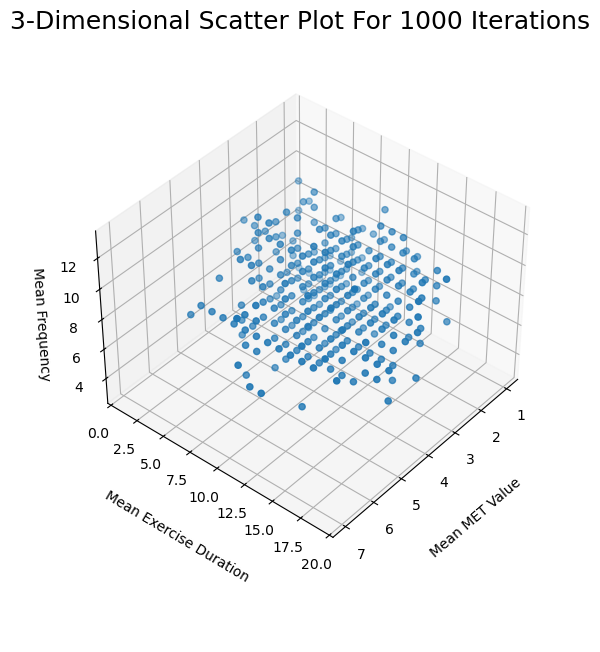

In [67]:
save_fig = False
elev = 40
azim = 40

data_points = melites.data_points()
    
xs = [dp[0] for dp in data_points]
ys = [dp[1] for dp in data_points]
zs = [dp[2] for dp in data_points]

fig = plt.figure(figsize=(6, 10))

# Add a 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(xs, ys, zs)

# Adding labels
ax.set_xlabel('Mean MET Value', labelpad=15)
ax.set_ylabel('Mean Exercise Duration', labelpad=15)
ax.set_zlabel('Mean Frequency')

# Adjust the view angle
ax.view_init(elev, azim)

fig.suptitle(f"3-Dimensional Scatter Plot For {iterations} Iterations", size=18, y=0.8)

# plt.subplots_adjust(bottom=0.3)
fig.text(0.5, 0.17, '\n', ha='center')

if save_fig:
    fig_name = f'plots/3d_scatter_{iterations}.png'
    plt.savefig(fig_name)

### Heat Map

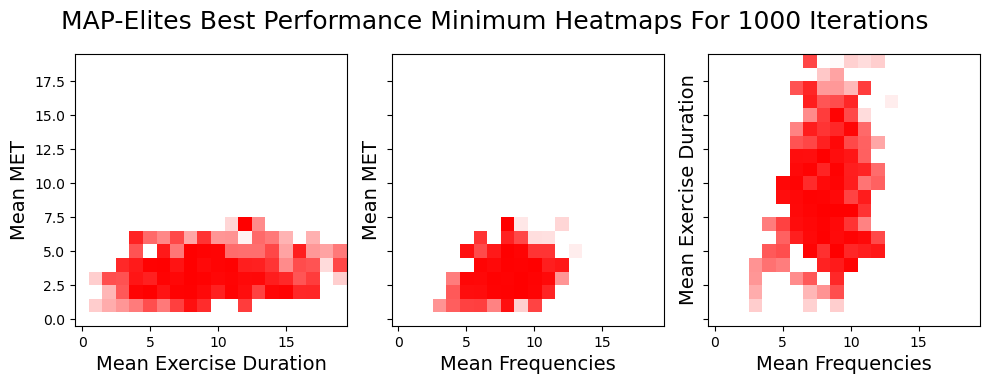

In [69]:
save_fig = False

colors = [(0, 'red'), (1, 'white')]
cmap = LinearSegmentedColormap.from_list('my_map', colors)
performances = melites.performances(True)

shape = (1, 3)
labels = ['Mean Exercise Duration', 'Mean MET', 'Mean Frequencies']
label_size = 14
performances_2d = [np.min(performances, axis=i) for i in range(2, -1, -1)]

fig, [ax1, ax2, ax3] = plt.subplots(shape[0], shape[1], figsize=(10, 12), sharey=True)

ax1.imshow(performances_2d[0], cmap=cmap, origin='lower')
ax2.imshow(performances_2d[1], cmap=cmap, origin='lower')
ax3.imshow(performances_2d[2], cmap=cmap, origin='lower')

ax1.set_xlabel(labels[0], fontsize=label_size)
ax2.set_xlabel(labels[2], fontsize=label_size)
ax3.set_xlabel(labels[2], fontsize=label_size)

ax1.set_ylabel(labels[1], fontsize=label_size)
ax2.set_ylabel(labels[1], fontsize=label_size)
ax3.set_ylabel(labels[0], fontsize=label_size)

plt.tight_layout()

# Adjusting layout for better spacing
fig.suptitle(
    f"MAP-Elites Best Performance Minimum Heatmaps For {iterations} Iterations",
    fontsize=18, y=0.65)

if save_fig:
    fig_name = f'plots/heatmap_{iterations}.png'
    plt.savefig(fig_name)

plt.show()

In [70]:
results.statistics()

,Mean,Standard Deviation,Maximum,Minimum
Performance,24.11,18.12,65.68,0.0
Exercise Duration,235.89,244.62,720.00,0.0
MET Value,4.55,4.30,19.80,0.0
Exercises/Day,2.22,1.25,6.00,0.0


In [71]:
# results.output()
results_df = results.statistics(True)
results_df

,mean_met,std_met,mean_duration,std_duration,week_schedule,total_exercises,mean_frequency,performance
0,0.400000,0.979796,21.428571,52.489066,0000010,1,1.000000,52.65
1,0.857143,0.989743,6.428571,7.423075,1101000,3,3.000000,53.71
2,2.000000,1.732051,8.571429,7.423075,0011101,4,4.000000,53.32
3,1.500000,3.674235,42.857143,104.978132,0000010,1,1.000000,44.22
4,1.428571,1.521948,46.071429,65.986432,1101111,7,3.500000,47.13
...,...,...,...,...,...,...,...,...
297,7.242857,6.106754,399.642857,265.232137,1111111,11,3.666667,45.29
298,8.035714,7.216955,263.035714,220.653815,1111111,19,3.800000,59.52
299,8.821429,4.173929,261.964286,226.831196,1111111,25,5.000000,54.99
300,8.535714,5.045735,275.357143,225.756382,1111111,14,3.500000,0.14


### Statistics Scatter Plot

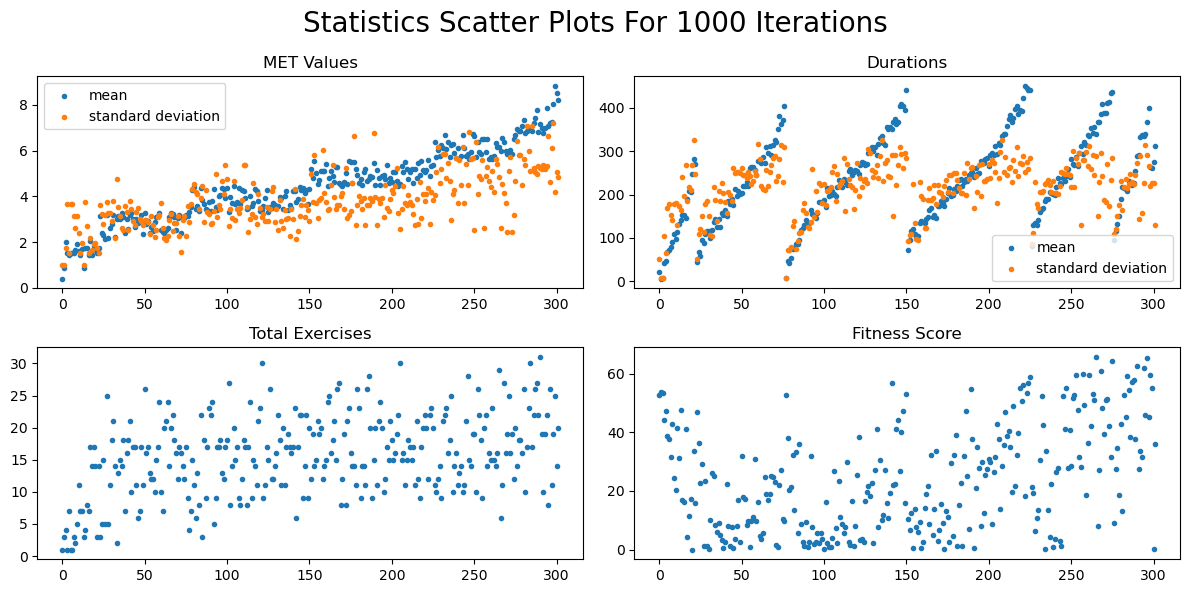

In [73]:
save_fig = False

# Transpose results
results_df_T = results_df.T

# MET Values
mean_mets = np.array(results_df_T.loc['mean_met'])
std_mets = np.array(results_df_T.loc['std_met'])

# Durations
mean_durs = np.array(results_df_T.loc['mean_duration'])
std_durs = np.array(results_df_T.loc['std_duration'])

# Total Exercises
total_exs = np.array(results_df_T.loc['total_exercises'])

# Performances
performances = np.array(results_df_T.loc['performance'])

# mean_mets = np.array(results_df_T.loc['mean_met'])

# Arrange data
data = [[mean_mets, std_mets], [mean_durs, std_durs], [total_exs], [performances]]
x = np.arange(len(results_df))
plot_titles = [
    'MET Values',
    'Durations',
    'Total Exercises',
    'Fitness Score'
]
line_type = ['mean','standard deviation']

# Create subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
axs = axs.flatten()  # Flatten 2D array of axes for easy indexing

for i in range(4):
    for j in range(len(data[i])):
        axs[i].scatter(x,data[i][j],label=('' if len(data[i]) == 1 else line_type[j]), marker='.')
        
    # axs[i].plot(x, y_values[i])
    axs[i].set_title(plot_titles[i])
    # axs[i].set_xlabel('X-axis')
    # axs[i].set_ylabel('Y-axis')
    # axs[i].grid(True)
    if len(data[i]) > 1:
        axs[i].legend()

fig.suptitle(f"Statistics Scatter Plots For {iterations} Iterations", fontsize=20)

# Hide the 8th subplot
# axs[7].axis('off')

if save_fig:
    fig_name = f'plots/scatter_plots_{iterations}.png'
    plt.savefig(fig_name)
    
plt.tight_layout()
plt.show()

In [74]:
def scale(arr: list | np.ndarray) -> np.ndarray:
    if isinstance(arr, list):
        arr = np.array(arr)
    scaled = np.array([0.0]*len(arr))
    hi = arr.max()
    for i in range(len(scaled)):
        scaled[i] = arr[i] / hi

    return scaled

l = np.random.uniform(1, 100, 20)
print(l)
scaled = scale(l)
print(scaled)

[76.95560235 43.01436826 24.85727373 83.23457119 49.44670405  9.12189553
 14.14058866 72.15812077 65.82753408 89.70887565 84.60205836 57.03601212
 25.92864317 23.65836802 90.93644052 32.1257347  66.38913194 66.83419158
 15.66198297 74.49098323]
[0.84625703 0.47301575 0.27334778 0.91530492 0.54375016 0.10031067
 0.15549969 0.79350061 0.7238851  0.98650085 0.93034275 0.62720744
 0.28512929 0.26016378 1.         0.3532768  0.73006082 0.734955
 0.17223    0.81915438]


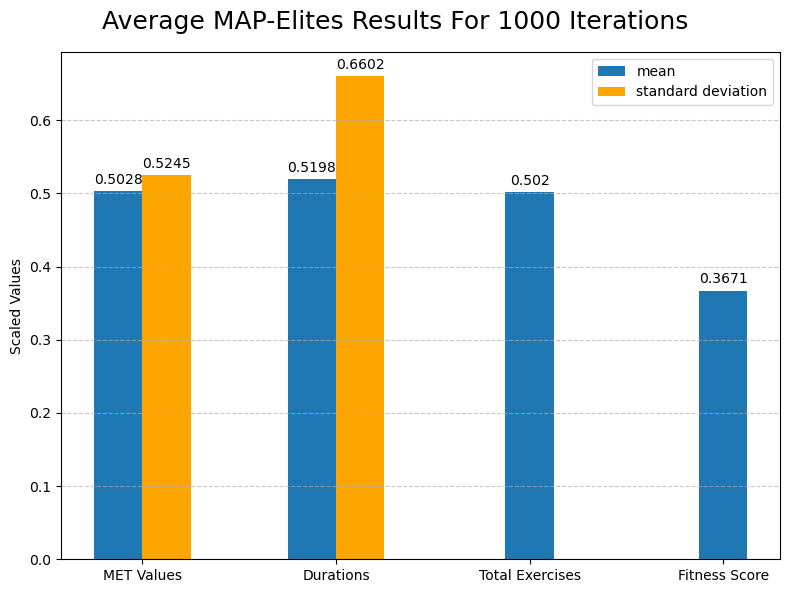

In [75]:
save_fig = False
categories = plot_titles

mean_mean_mets = round(scale(mean_mets).mean(), 4)
mean_std_mets = round(scale(std_mets).mean(), 4)

mean_mean_durs = round(scale(mean_durs).mean(), 4)
mean_std_durs = round(scale(std_durs).mean(), 4)

mean_total_exs = round(scale(total_exs).mean(), 4)

mean_performance = round(scale(performances).mean(), 4)

mean_color = '#1f77b4'
std_color = 'orange'

x = np.arange(len(plot_titles))
bar_width = 0.5

fig, ax = plt.subplots(figsize=(8, 6))

# Plot sub-bars for Group 1 and Group 2
b1 = ax.bar(x[0]-bar_width/4, mean_mean_mets, width=bar_width/2, label='mean', color=mean_color)
b2 = ax.bar(x[0]+bar_width/4, mean_std_mets, width=bar_width/2, label='standard deviation', color=std_color)

b3 = ax.bar(x[1]-bar_width/4, mean_mean_durs, width=bar_width/2, color=mean_color)
b4 = ax.bar(x[1]+bar_width/4, mean_std_durs, width=bar_width/2, color=std_color)

# Plot regular bars for Group 3 and Group 4
b5 = ax.bar(x[2], mean_total_exs, width=bar_width/2, label='', color=mean_color)
b6 = ax.bar(x[3], mean_performance, width=bar_width/2, label='', color=mean_color)

bars = [b1, b2, b3, b4, b5, b6]

for b in bars:
    ax.bar_label(b, padding=3)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_ylabel('Scaled Values')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

fig.suptitle(f"Average MAP-Elites Results For {iterations} Iterations", fontsize=18)

if save_fig:
    fig_name = f'plots/bar_plots_{iterations}.png'
    plt.savefig(fig_name)

plt.tight_layout()
plt.show()